In [1]:
import pandas as pd
import numpy as np
from scipy.stats import expon
from tqdm.notebook import tqdm
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
def round_to(x, rounding_val):
    return np.round(x / rounding_val) * rounding_val

In [3]:
mpl.rcParams["figure.figsize"] = (15,8)
plt.style.use("bmh")

# Exponential

$l(\lambda ; b_0, ..., b_n) = \sum_{j=0}^{\infty}{ b_j \left( \log(1 - e^{-d \lambda}) - jd \lambda \right)}$.

$\frac{\partial l}{\partial \lambda} = = \sum_{j=0}^{\infty}{ b_j \left( \frac{d}{e^{d \lambda} - 1} - jd\right)}$

$\frac{\partial^2 l}{\partial \lambda^2} = -\frac{d^2}{(e^{d \lambda} - 1)^2} \sum_{j=0}^{\infty}{ b_j }$.

In [4]:
def generate_exp_samples_with_bins(sample_size, lambda_, bin_size):
    exp = expon(scale=1/lambda_)
    sample = pd.DataFrame(exp.rvs(sample_size), columns=['x'])
    sample['bin_j'] = sample['x'].apply(lambda x: int(np.floor(x/bin_size)))
    return sample

def get_bin_counts(sample):
    bin_counts = pd.DataFrame(sample['bin_j'].value_counts()).sort_index()
    return bin_counts

In [5]:
def exp_log_likeli(lambda_, sample):
    return len(sample) * np.log(lambda_) - lambda_ * sample['x'].sum()

def exp_fisher(lambda_, n):
    return n/(lambda_**2)

def exp_bin_log_likeli(lambda_, bjs, bin_size):
    return (
        bjs['bin_j'] * (
            np.log(1 - np.exp(-bin_size * lambda_))
            - bin_size * lambda_ * bjs.index
        )
    ).sum()

# optimising for lambda_, so want to run over many lambda_ values, so vectorize over just this
exp_bin_log_likeli = np.vectorize(exp_bin_log_likeli, excluded=[1, 2])

def exp_bin_fisher_info(lambda_, n, bin_size):
    return n * bin_size**2 / (np.exp(bin_size * lambda_) - 1)**2

In [6]:
sample_size = 1000
lambda_ = 1
bin_size = 3

sample = generate_exp_samples_with_bins(sample_size, lambda_, bin_size)
bjs = get_bin_counts(sample)

In [7]:
lambdas = np.linspace(0.01, 4, num=1000)
binned_log_likelihoods = exp_bin_log_likeli(lambdas, bjs, bin_size)
log_likelihoods = exp_log_likeli(lambdas, sample)
lambda_hat = lambdas[np.argmax(log_likelihoods)]
binned_lambda_hat = lambdas[np.argmax(binned_log_likelihoods)]

True Value: 1, MLE: 1.0644144144144145, Binned MLE: 1.1203303303303305


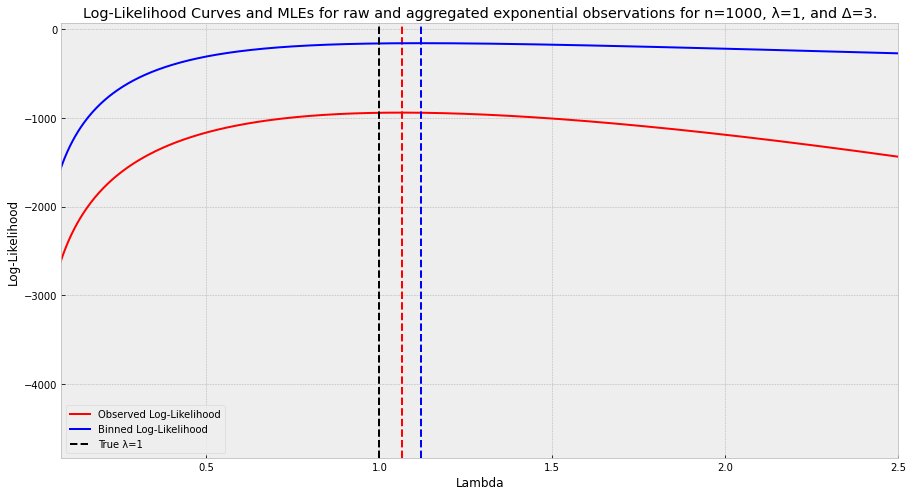

In [8]:
plt.figure()
plt.plot(lambdas, log_likelihoods, label='Observed Log-Likelihood', c='red')
plt.axvline(x=lambda_hat, c='red', ls='--')
plt.plot(lambdas, binned_log_likelihoods, label='Binned Log-Likelihood', c='blue')
plt.axvline(x=binned_lambda_hat, c='blue', ls='--')
plt.axvline(x=lambda_, c='black', ls='--', label=f'True λ={lambda_}')
plt.legend()
plt.ylabel('Log-Likelihood')
plt.xlabel('Lambda')
plt.title(f'Log-Likelihood Curves and MLEs for raw and aggregated exponential observations for n={sample_size}, λ={lambda_}, and Δ={bin_size}.')
plt.xlim(0.08, 2.5)
# plt.savefig("./thesis/exp_log_likelihood.pdf")
print(f"True Value: {lambda_}, MLE: {lambda_hat}, Binned MLE: {binned_lambda_hat}")

## Fisher Information as $\frac{n}{d} \to \infty$

\begin{equation*}
    \begin{aligned}
        \text{Set } d &:= \log(\log(n)). \\
        \mathcal{I}(\lambda) &= \frac{n (\log(\log(n)))^2}{(e^{\lambda \log(\log(n))} - 1)^2} \\
        &= \frac{n (\log(\log(n)))^2}{(\log(n)^{\lambda} - 1)^2} \\
        &= \frac{n (\log(\log(n)))^2}{\log(n)^{2 \lambda} - 2 \log(n)^{\lambda} + 1} \\
        &= \frac{O(n (\log(\log(n)))^2)}{O(\log(n)^{2 \lambda})} \to \infty \text{ as } n \to \infty.
    \end{aligned}
\end{equation*}

In [9]:
def loglogn_info(n, lam):
    return (n * np.log(np.log(n))**2) / (np.log(n)**lam - 1)**2
    
loglogn_info = np.vectorize(loglogn_info)

\begin{equation*}
    \begin{aligned}
        \text{Set } d &:= \frac{1}{p}\log(n). \\
        \mathcal{I}(\lambda) &= \frac{\frac{1}{p^2} n \log(n)^2}{(e^{\frac{\lambda}{p} \log(n)} - 1)^2} \\
        &= \frac{\frac{1}{p^2} n \log(n)^2}{n^{\frac{2 \lambda}{p}} - 2n^{\frac{\lambda}{p}} + 1} \\
        &= \frac{O(n \log(n)^2)}{O(n^{\frac{2\lambda}{p}})} \to 0 \text{ if } \lambda > \frac{p}{2}
    \end{aligned}
\end{equation*}

In [10]:
def plogn_info(n, p, lam):
    return (1/p**2 * n * np.log(n)**2) / (n**(lam/p) - 1)**2
plogn_info = np.vectorize(plogn_info)

In [11]:
ns = np.linspace(30, 3000, num=200)
lam = 2
p = 4

loglog_infos = loglogn_info(ns, lam)
plog_infos = plogn_info(ns, p, lam)

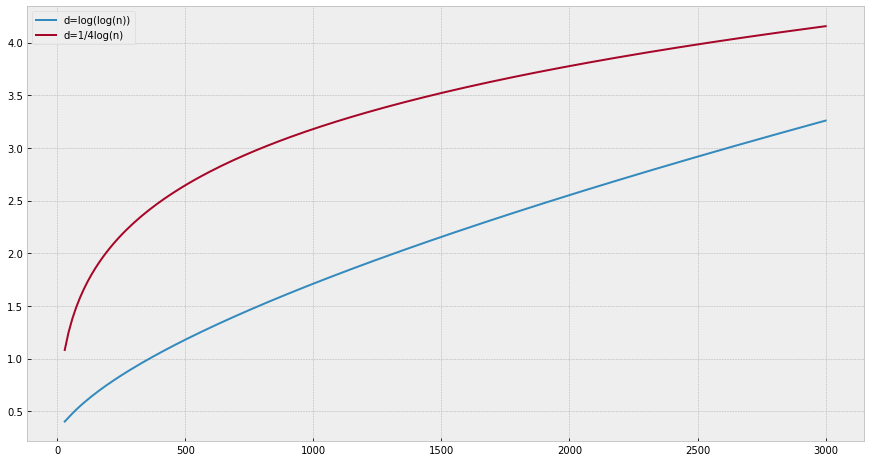

In [12]:
plt.plot(ns, loglog_infos, label=f'd=log(log(n))')
plt.plot(ns, plog_infos, label=f'd=1/{p}log(n)')
plt.legend()

In [13]:
bin_sizes = np.linspace(0.00000001, 4, num=600)

In [14]:
infos_05 = np.array([exp_bin_fisher_info(0.5, 1, bin_size) for bin_size in bin_sizes])
infos_1 = np.array([exp_bin_fisher_info(1, 1, bin_size) for bin_size in bin_sizes])
infos_3 = np.array([exp_bin_fisher_info(3, 1, bin_size) for bin_size in bin_sizes])
infos_5 = np.array([exp_bin_fisher_info(5, 1, bin_size) for bin_size in bin_sizes])

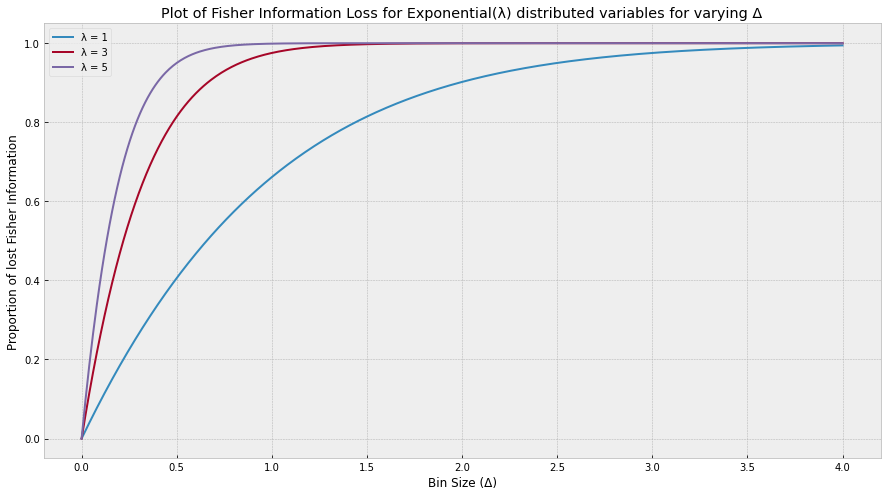

In [16]:
# plt.plot(bin_sizes, 1 - infos_05/exp_fisher(0.5, 1), label='λ = 0.5')
plt.plot(bin_sizes, 1 - infos_1/exp_fisher(1, 1), label='λ = 1')
plt.plot(bin_sizes, 1 - infos_3/exp_fisher(3, 1), label='λ = 3')
plt.plot(bin_sizes, 1 - infos_5/exp_fisher(5, 1), label='λ = 5')
plt.xlabel('Bin Size (Δ)')
plt.ylabel('Proportion of lost Fisher Information')
plt.title('Plot of Fisher Information Loss for Exponential(λ) distributed variables for varying Δ')
plt.legend()
# plt.savefig("./thesis/exp_info_loss.pdf")